In [26]:
import rpy2
import rpy2.robjects
from rpy2.robjects.packages import importr

In [27]:
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()

In [28]:
import os
import sys

nb_dir_1 = os.path.split(os.getcwd())[0]
current_path = os.getcwd()
parent = os.path.dirname(current_path)
nb_dir_2 = os.path.split(parent)[0]

if nb_dir_1 not in sys.path:
    sys.path.append(nb_dir_1)

if nb_dir_2 not in sys.path:
    sys.path.append(nb_dir_2)

In [29]:
import numpy as np
import pandas as pd
import torch
from core.models import LSTM
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import scipy.stats
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from core.data_preparation import DataPreparation
from core.curve_fit import fit_polynomial_curve_to_data_and_visualize

In [30]:
# Importing local modules (statistical distance measures)
from CVM_Distance import CVM_Dist as Cramer_Von_Mises_Dist
from Anderson_Darling_Distance import Anderson_Darling_Dist
from Kolmogorov_Smirnov_Distance import Kolmogorov_Smirnov_Dist
from KuiperDistance import Kuiper_Dist
from WassersteinDistance import Wasserstein_Dist
from DTS_Distance import DTS_Dist # Combo of Anderson_Darling and CVM distance.

In [31]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


In [32]:
filepath = "../Data/TECHM_2010-01-012022-01-09.csv"
data = pd.read_csv(filepath, usecols=[0,4], names=['date', 'close'], header=0)
data = data.sort_values('date')
data['date'] = pd.to_datetime(data['date'])
data.head()

,date,close
0,2010-01-04,1023.0
1,2010-01-05,1036.1
2,2010-01-06,1041.2
3,2010-01-07,1018.3
4,2010-01-08,1045.1


In [33]:
data.tail()

,date,close
2981,2022-01-03,1784.80
2982,2022-01-04,1789.80
2983,2022-01-05,1737.55
2984,2022-01-06,1692.10
2985,2022-01-07,1703.85


In [34]:
data['close'].isnull().values.any()

False

In [35]:
# data[data['date'] == '2013-01-02'].index

In [36]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='closing price'))

fig.update_layout(
    title="TechM stock closing price from 2010 to January 2022",
    xaxis_title="Date",
    yaxis_title="Closing price in INR",    
    font=dict(
        family="Ariale",
        size=16       
    )
)

In [37]:
TsAD = importr('otsad')
TSdist = importr('TSdist')

In [38]:
train_len = 0.8*len(data)

In [39]:
res = TsAD.OcpTsSdEwma(data['close'].values, train_len, 0.01, 3, 20)

In [40]:
df = pd.DataFrame(res)

In [41]:
df.head()

,is.anomaly,lcl,ucl
0,0.0,1023.0,1023.0
1,0.0,1036.1,1036.1
2,0.0,1041.2,1041.2
3,0.0,1018.3,1018.3
4,0.0,1045.1,1045.1


In [42]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['close'], mode='lines', name='close price'))
fig.add_trace(go.Scatter(x=df.index, y=df['lcl'], mode='lines', name='lower control limit'))
fig.add_trace(go.Scatter(x=df.index, y=df['ucl'], mode='lines', name='upper control limit'))

In [43]:
anomaly_indices = df[df['is.anomaly'] == 1.0].index

In [44]:
rows = data.iloc[anomaly_indices, :]

In [45]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['date'], y=data['close'], mode='lines', name='closing price'))
fig.add_trace(go.Scatter(x=rows['date'], y=rows['close'], mode='markers', name='anomalies'))

In [46]:
window_size = 20
prep = DataPreparation()
scaler = MinMaxScaler(feature_range=(-1, 1))

In [47]:
train_set, test_set = prep.splitData(data['close'].values)

In [48]:
scaler, x_train, x_test, y_train_lstm, y_test_lstm = prep.normalize_and_prepare_data(data['close'].values, scaler)

x_train.shape =  (2369, 20, 1)
y_train.shape =  (2369, 1)
x_test.shape =  (577, 20, 1)
y_test.shape =  (577, 1)


In [49]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

hist = np.zeros(num_epochs)
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step() 

In [50]:
torch.save(model, 'lstm_techm.pt')

In [51]:
actual_test_len = len(test_set) - window_size

In [52]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
test_error = mean_absolute_percentage_error(y_test[:,0], y_test_pred[:,0])
accuracy_reg = r2_score(y_test[:, 0], y_test_pred[:, 0])
rmse = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f MAPE' % (test_error))
print(f'R-squared value is {accuracy_reg}')
print('RMSE: ', rmse)

preds = y_test_pred[:, 0]
gt = y_test[:, 0]

Test Score: 0.02 MAPE
R-squared value is 0.9924494951088682
RMSE:  27.880000602470403


In [53]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index[-actual_test_len:], y=y_test[:,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y=df['lcl'][-actual_test_len:], mode='lines', name='lower control limit'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y=df['ucl'][-actual_test_len:], mode='lines', name='upper control limit'))
fig.add_trace(go.Scatter(x=df.index[-actual_test_len:], y= y_test_pred[:,0], mode='lines', name='predicted close price'))


#### Find distance between forecast distributions and actual test values using different distance measures from R

### Dynamic Time Warping

In [54]:
dtw_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  dtw = TSdist.DTWDistance(X1, X2)
  dtw_dist.append(dtw.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "DTW distance" : dtw_dist

    }

df1 = pd.DataFrame(finalResult)

In [55]:
pdc_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  pdc = TSdist.PDCDistance(X1, X2)
  pdc_dist.append(pdc.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "PDC distance" : pdc_dist

    }

df2 = pd.DataFrame(finalResult)

In [56]:
cort_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  # print(X2.shape)

  ## convert to np.array
  X1 = rpy2.robjects.FloatVector(X1)
  X2 = rpy2.robjects.FloatVector(X2)

  # print(type(X1))

  cort = TSdist.CortDistance(X1, X2, deltamethod="DTW")
  cort_dist.append(cort.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "Temporal Correlation distance" : cort_dist

    }

df3 = pd.DataFrame(finalResult)

In [57]:
df3

,range,Temporal Correlation distance
0,0 : 100,788.552595
1,100 : 200,1200.986378
2,200 : 300,1165.956359
3,300 : 400,1458.715731
4,400 : 500,1138.179651


In [58]:
fourier_dist = []
test_set_range = []

for i in range(5):

  X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

  ## convert to np.array
  X1 = rpy2.robjects.FloatVector(X1)
  X2 = rpy2.robjects.FloatVector(X2)

  fourier = TSdist.FourierDistance(X1, X2)
  fourier_dist.append(fourier.item())
  test_set_range.append(f'{i*100} : {(i+1)*100}')

finalResult = { "range" : test_set_range,    
    "Fourier distance" : fourier_dist

    }

df4 = pd.DataFrame(finalResult)

In [59]:
df4

,range,Fourier distance
0,0 : 100,1038.975357
1,100 : 200,2277.339084
2,200 : 300,1964.057878
3,300 : 400,1915.430524
4,400 : 500,1660.106095


#### KL divergence

In [60]:
def computeKLD(X1, X2, bins=5):

    # values_1, edges_1 = np.histogram(X1,bins=bins,density=True)
    # values_2, edges_2 = np.histogram(X2,bins=bins,density=True)

    values_1, edges_1 = np.histogram(X1,bins=bins)
    values_2, edges_2 = np.histogram(X2,bins=bins)
   
    #Consider only first std. deviation of original series i.e. P(x).    
    P = values_1
    Q = values_2
    delta_x = 2/bins
    res =  np.sum( P * np.log2( P/Q )) * delta_x
    return res

In [61]:
KLD = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    kld_res = computeKLD(X1, X2)

    KLD.append(kld_res)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "KL divergence" : KLD

}

df5 = pd.DataFrame(finalResult)

#### Jensen Shannon Divergence

In [62]:
def jsd(p, q, base=np.e):
    '''
        Implementation of pairwise `jsd` based on  
        https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    '''
    if len(p)>len(q):
        p = np.random.choice(p,len(q)) # random.choice make same length to p/q
    elif len(q)>len(p):
        q = np.random.choice(q,len(p))
    ## convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    ## normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    
    return scipy.stats.entropy(p,m, base=base)/2. +  scipy.stats.entropy(q, m, base=base)/2

In [63]:
JSD = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    jsd_res = jsd(X1, X2)

    JSD.append(jsd_res)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "JS divergence" : JSD

}

df6 = pd.DataFrame(finalResult)

In [64]:
result = pd.concat([df1, df2['PDC distance'], df3['Temporal Correlation distance'],
 df4['Fourier distance'], df5['KL divergence'], df6['JS divergence']], axis=1)
result

,range,DTW distance,PDC distance,Temporal Correlation distance,Fourier distance,KL divergence,JS divergence
0,0 : 100,663.569946,0.736518,788.552595,1038.975357,4.004004,0.000024
1,100 : 200,1358.429718,0.916312,1200.986378,2277.339084,12.057296,0.000318
2,200 : 300,1093.135803,1.223310,1165.956359,1964.057878,1.162700,0.000096
3,300 : 400,1334.497437,1.063869,1458.715731,1915.430524,3.550898,0.000089
4,400 : 500,1322.942932,0.787739,1138.179651,1660.106095,0.081457,0.000050


In [65]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index[-len(x_test):], y=data['close'][-len(x_test):], mode='lines', name='closing price'))

In [66]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[:100], y=y_test[:100,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[:100], y= y_test_pred[:100,0], mode='lines', name='predicted close price'))

In [67]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[100:200], y=y_test[100:200,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[100:200], y= y_test_pred[100:200,0], mode='lines', name='predicted close price'))

In [68]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[200:300], y=y_test[200:300,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[200:300], y= y_test_pred[200:300,0], mode='lines', name='predicted close price'))

In [69]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[300:400], y=y_test[300:400,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[300:400], y= y_test_pred[300:400,0], mode='lines', name='predicted close price'))

In [70]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index[400:500], y=y_test[400:500,0], mode='lines', name='actual close price'))
fig.add_trace(go.Scatter(x=df.index[400:500], y= y_test_pred[400:500,0], mode='lines', name='predicted close price'))

#### Measure how accuracy of model changes with shift in test set

In [71]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*100} : {(i+1)*100}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df = pd.DataFrame(accuracy)

In [72]:
acc_df

,range,RMSE,MAPE,R2-score
0,0 : 100,12.764123,1.375712,0.826874
1,100 : 200,31.379096,3.827221,0.918643
2,200 : 300,24.372888,2.688944,0.915092
3,300 : 400,26.671535,2.173912,0.562638
4,400 : 500,23.476813,1.591690,0.982183


In [73]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(8):
    
    X1, X2 = gt[i*70 : (i+1)*70], preds[i*70 : (i+1)*70]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*70} : {(i+1)*70}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df2 = pd.DataFrame(accuracy)

In [74]:
acc_df2

,range,RMSE,MAPE,R2-score
0,0 : 70,13.200068,1.435072,0.759012
1,70 : 140,34.355037,3.626027,0.900875
2,140 : 210,18.959705,2.849893,0.633199
3,210 : 280,25.747875,2.872390,0.848498
4,280 : 350,25.693701,2.091469,0.869906
5,350 : 420,22.837132,1.825665,0.123657
6,420 : 490,26.207730,1.795178,0.969269
7,490 : 560,38.553507,2.056039,0.730665


In [75]:
r2_list = []
rmse_list = []
mape_list = []
test_set_range = []

for i in range(11):
    
    X1, X2 = gt[i*50 : (i+1)*50], preds[i*50 : (i+1)*50]

    rmse = math.sqrt(mean_squared_error(X1, X2))
    mape = mean_absolute_percentage_error(X1, X2) * 100
    r2 = r2_score(X1, X2)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2)
    
    test_set_range.append(f'{i*50} : {(i+1)*50}')
    

accuracy = { "range" : test_set_range,             
        "RMSE" : rmse_list,
        "MAPE" : mape_list,
        "R2-score": r2_list
}

acc_df3 = pd.DataFrame(accuracy)

In [76]:
acc_df3

,range,RMSE,MAPE,R2-score
0,0 : 50,13.646713,1.499195,0.726430
1,50 : 100,11.815790,1.252229,0.527447
2,100 : 150,40.055982,4.756217,0.907946
3,150 : 200,19.100090,2.898224,0.394530
4,200 : 250,24.991894,3.144899,0.821427
5,250 : 300,23.737745,2.232989,0.316168
6,300 : 350,27.725872,2.241038,0.664881
7,350 : 400,25.573771,2.106787,0.070120
8,400 : 450,16.757285,1.310578,0.875997
9,450 : 500,28.662083,1.872803,0.964999


#### ECDF distance measures between actual values and forecasts

In [77]:
wasserstein_distance = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = Wasserstein_Dist(X1, X2)

    wasserstein_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "Wasserstein distance" : wasserstein_distance

}

df7 = pd.DataFrame(finalResult)

In [78]:
KS_distance = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = Kolmogorov_Smirnov_Dist(X1, X2)

    KS_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "Kolmogorov Smirnov distance" : KS_distance

}

df8 = pd.DataFrame(finalResult)

In [79]:
DTS_distance = []
test_set_range = []

for i in range(5):
    
    X1, X2 = gt[i*100 : (i+1)*100], preds[i*100 : (i+1)*100]

    dist = DTS_Dist(X1, X2)

    DTS_distance.append(dist)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



finalResult = { "range" : test_set_range,             
        "DTS distance" : DTS_distance

}

df9 = pd.DataFrame(finalResult)

In [80]:
result = pd.concat([df7, df8['Kolmogorov Smirnov distance'], df9['DTS distance']], axis=1)
result

,range,Wasserstein distance,Kolmogorov Smirnov distance,DTS distance
0,0 : 100,7.488015,0.14,1.693445
1,100 : 200,11.024187,0.14,2.277939
2,200 : 300,13.470651,0.12,2.898630
3,300 : 400,8.550024,0.16,1.801844
4,400 : 500,11.814942,0.10,2.258435


#### ECDF distance measures between train set and test set

In [81]:
dtw_dist = []
test_set_range = []

for i in range(8):

  X1, X2 = train_set, gt[i*70 : (i+1)*70]

  ## convert to np.array
  X1, X2 = np.asarray(X1), np.asarray(X2)

  dtw = TSdist.DTWDistance(X1, X2)
  dtw_dist.append(np.round(dtw.item(), 2))
  test_set_range.append(f'{i*70} : {(i+1)*70}')

finalResult_dtw = { "range" : test_set_range,    
    "DTW distance" : dtw_dist,

    }

df_dtw = pd.DataFrame(finalResult_dtw)

In [82]:
df_dtw

,range,DTW distance
0,0 : 70,789643.43
1,70 : 140,653358.29
2,140 : 210,839248.18
3,210 : 280,790229.61
4,280 : 350,872394.37
5,350 : 420,973969.73
6,420 : 490,1140364.08
7,490 : 560,1710499.20


In [83]:
def get_statistical_dist_measures(X_train, X_test):   

    CVM_distance = Cramer_Von_Mises_Dist(X_train, X_test)
    Anderson_Darling_distance = Anderson_Darling_Dist(X_train, X_test)
    Kolmogorov_Smirnov_distance = Kolmogorov_Smirnov_Dist(X_train, X_test)
    Kuiper_distance = Kuiper_Dist(X_train, X_test)
    Wasserstein_distance = Wasserstein_Dist(X_train, X_test)
    DTS_distance = DTS_Dist(X_train, X_test)   
    
    # Returning dictionary, for efficient and fast DataFrame creation. Returns mean for each distance.
    # See https://stackoverflow.com/a/17496530. Fast way to 'append' to dataframe for results table.
    # PRESERVE THE ORDERING
    return {'Anderson_Darling_dist': Anderson_Darling_distance,
            'CVM_dist': CVM_distance,
            'DTS_dist':DTS_distance,
            'Kolmogorov_Smirnov_dist':Kolmogorov_Smirnov_distance,
            'Kuiper_dist': Kuiper_distance,
            'Wasserstein_dist': Wasserstein_distance}

In [84]:
test_set_range = []
finalResult = []

for i in range(5):
    
    X1, X2 = train_set, gt[i*100 : (i+1)*100]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult.append(distances)
    test_set_range.append(f'{i*100} : {(i+1)*100}')



In [85]:
test_set_range = []
finalResult2 = []

for i in range(8):
    
    X1, X2 = train_set, gt[i*70 : (i+1)*70]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult2.append(distances)
    test_set_range.append(f'{i*70} : {(i+1)*70}')



In [86]:
df = pd.DataFrame(finalResult)
# df.insert(0, 'Test set range', test_set_range)
frames = [acc_df[['RMSE',  'R2-score', 'MAPE']], df]
df = pd.concat(frames, axis=1)
df

#As distance between train and test increases, model's performance decreases. We should analyse this point here.
# Only DTS_dist and Wasserstein_dist are positively correlated to model's accuracy.

,RMSE,R2-score,MAPE,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,12.764123,0.826874,1.375712,24.544055,527.957585,18.945886,0.505697,0.809171,332.176793
1,31.379096,0.918643,3.827221,21.542532,457.697932,18.332931,0.445689,0.612332,318.901260
2,24.372888,0.915092,2.688944,19.495116,405.420117,17.438965,0.286810,0.571448,296.623131
3,26.671535,0.562638,2.173912,32.418537,714.853508,22.810145,0.711595,0.893679,425.932859
4,23.476813,0.982183,1.591690,35.183118,773.375010,24.610595,0.766848,0.915027,468.693441


In [87]:
res = pd.concat([acc_df[['RMSE',  'R2-score', 'MAPE']], df[['DTS_dist', 'Wasserstein_dist', 'CVM_dist']]], axis=1)
res = res.style.set_caption("Correlation between accuracy of prediction models with different distance measures").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('text-align', 'center'),
        ('color', 'black') ,       
        ('font-size', '18px'),
        ('font-family', 'Arial')
    ]
}])
# res = res.style.set_caption('Correlation between accuracy of prediction models with different distance measures')
res

,RMSE,R2-score,MAPE,DTS_dist,Wasserstein_dist,CVM_dist
0,12.764123,0.826874,1.375712,18.945886,332.176793,527.957585
1,31.379096,0.918643,3.827221,18.332931,318.901260,457.697932
2,24.372888,0.915092,2.688944,17.438965,296.623131,405.420117
3,26.671535,0.562638,2.173912,22.810145,425.932859,714.853508
4,23.476813,0.982183,1.591690,24.610595,468.693441,773.375010


In [88]:
df1 = pd.DataFrame(finalResult2)
df1.insert(0, 'Test set range', test_set_range)
df1

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 70,23.614099,502.938540,18.895654,0.501411,0.827908,329.956909
1,70 : 140,17.059245,349.771949,16.932595,0.334210,0.627639,285.005947
2,140 : 210,29.338711,642.419757,20.507062,0.653830,0.830473,369.577057
3,210 : 280,20.398772,425.698045,17.742194,0.358620,0.644932,303.050968
4,280 : 350,29.409543,644.568648,20.907130,0.686480,0.868564,380.918461
5,350 : 420,32.949192,721.596914,23.434956,0.739221,0.924236,437.024137
6,420 : 490,35.817877,780.792095,25.506407,0.801591,0.949770,484.041837
7,490 : 560,39.159618,844.305890,40.173496,0.847635,0.987024,769.134791


In [89]:
frames = [df1[['Test set range']], acc_df2[['RMSE',  'R2-score', 'MAPE']], df1.iloc[:, 1:]]
df1 = pd.concat(frames, axis=1)
df1


,Test set range,RMSE,R2-score,MAPE,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 70,13.200068,0.759012,1.435072,23.614099,502.938540,18.895654,0.501411,0.827908,329.956909
1,70 : 140,34.355037,0.900875,3.626027,17.059245,349.771949,16.932595,0.334210,0.627639,285.005947
2,140 : 210,18.959705,0.633199,2.849893,29.338711,642.419757,20.507062,0.653830,0.830473,369.577057
3,210 : 280,25.747875,0.848498,2.872390,20.398772,425.698045,17.742194,0.358620,0.644932,303.050968
4,280 : 350,25.693701,0.869906,2.091469,29.409543,644.568648,20.907130,0.686480,0.868564,380.918461
5,350 : 420,22.837132,0.123657,1.825665,32.949192,721.596914,23.434956,0.739221,0.924236,437.024137
6,420 : 490,26.207730,0.969269,1.795178,35.817877,780.792095,25.506407,0.801591,0.949770,484.041837
7,490 : 560,38.553507,0.730665,2.056039,39.159618,844.305890,40.173496,0.847635,0.987024,769.134791


In [90]:
res = pd.concat([acc_df2[['RMSE',  'R2-score', 'MAPE']], df1[['DTS_dist', 'Wasserstein_dist', 'CVM_dist']], df_dtw[['DTW distance']]], axis=1)
res = res.style.set_caption("Correlation between accuracy of prediction models with different distance measures").set_table_styles([{
    'selector': 'caption',
    'props': [
        ('text-align', 'center'),
        ('color', 'black') ,       
        ('font-size', '18px'),
        ('font-family', 'Arial')
    ]
}])
# res = res.style.set_caption('Correlation between accuracy of prediction models with different distance measures')
res

,RMSE,R2-score,MAPE,DTS_dist,Wasserstein_dist,CVM_dist,DTW distance
0,13.200068,0.759012,1.435072,18.895654,329.956909,502.938540,789643.430000
1,34.355037,0.900875,3.626027,16.932595,285.005947,349.771949,653358.290000
2,18.959705,0.633199,2.849893,20.507062,369.577057,642.419757,839248.180000
3,25.747875,0.848498,2.872390,17.742194,303.050968,425.698045,790229.610000
4,25.693701,0.869906,2.091469,20.907130,380.918461,644.568648,872394.370000
5,22.837132,0.123657,1.825665,23.434956,437.024137,721.596914,973969.730000
6,26.207730,0.969269,1.795178,25.506407,484.041837,780.792095,1140364.080000
7,38.553507,0.730665,2.056039,40.173496,769.134791,844.305890,1710499.200000


In [91]:
test_set_range = []
finalResult3 = []

for i in range(11):
    
    X1, X2 = train_set, gt[i*50 : (i+1)*50]

    distances = get_statistical_dist_measures(X1, X2)

    finalResult3.append(distances)
    test_set_range.append(f'{i*50} : {(i+1)*50}')



In [92]:
df3 = pd.DataFrame(finalResult3)
df3.insert(0, 'Test set range', test_set_range)
df3.head()

,Test set range,Anderson_Darling_dist,CVM_dist,DTS_dist,Kolmogorov_Smirnov_dist,Kuiper_dist,Wasserstein_dist
0,0 : 50,22.460851,473.589192,18.731326,0.495697,0.833077,325.414145
1,50 : 100,26.874719,581.033972,19.606636,0.626622,0.930096,346.957134
2,100 : 150,12.801446,246.495588,16.037490,0.293428,0.458861,263.227915
3,150 : 200,29.771465,649.803759,20.772574,0.698619,0.875262,374.777697
4,200 : 250,15.904052,313.961507,17.398574,0.319799,0.603181,293.184888


In [93]:
y_values = 100 - acc_df2['MAPE']
# y_values

In [94]:
fig = px.scatter(x=df1['Wasserstein_dist'], y=y_values, labels=dict(x="Dissimilarity (Wasserstein distance)", y="Accuracy (100-MAPE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

In [95]:
fig = px.scatter(x=df1['Wasserstein_dist'], y=df1['RMSE'], labels=dict(x="Dissimilarity (Wasserstein distance)", y="Performance (RMSE)"))
fig.update_traces(marker = dict(size=10, color='red'))
fig.show()

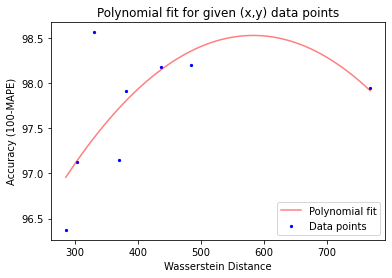

In [104]:
fit_polynomial_curve_to_data_and_visualize(df1['Wasserstein_dist'].values, ys, xlabel='Wasserstein Distance', ylabel='Accuracy (100-MAPE)')

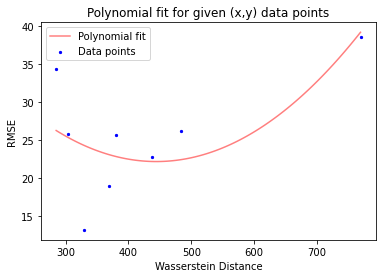

In [105]:
fit_polynomial_curve_to_data_and_visualize(df1['Wasserstein_dist'].values, df1['RMSE'].values, xlabel='Wasserstein Distance', ylabel='RMSE')

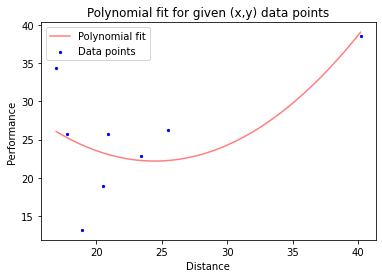

In [118]:
fit_polynomial_curve_to_data_and_visualize(df1['DTS_dist'].values, df1['RMSE'].values)